In [2]:
# Import necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D, concatenate
)
import string

# Set paths and configurations
INPUT_PATH = "/kaggle/input"
DATASET_PATH = os.path.join(INPUT_PATH, "indian-sign-language-isl/Indian")
PROCESSED_DATA_PATH = "/kaggle/working/processed_data"
IMAGE_SIZE = (128, 128)  # Image size increased to 128x128
BATCH_SIZE = 1
EPOCHS = 10
NUM_CLASSES = 36  # A-Z + 0-9

# Ensure GPU memory growth is enabled
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Map labels (A-Z + 0-9) to unique integers
LABEL_MAP = {char: idx for idx, char in enumerate(string.ascii_uppercase + string.digits)}

# Data Generator for batch loading
class DataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=BATCH_SIZE, target_size=IMAGE_SIZE, augment=False, **kwargs):
        super().__init__(**kwargs)
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment

        if self.augment:
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.array([self.load_image(p) for p in batch_paths])
        y = np.array(batch_labels)
        return X, y

    def load_image(self, image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, self.target_size)
        img_normalized = img_resized / 255.0
        return np.expand_dims(img_normalized, axis=-1)  # Add channel dimension

# Define different models
def simple_cnn():
    model = Sequential([
        Input(shape=(128, 128, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def deep_cnn():
    model = Sequential([
        Input(shape=(128, 128, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def resnet_model():
    input_layer = Input(shape=(128, 128, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    res = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = concatenate([x, res])
    x = GlobalAveragePooling2D()(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def inception_model():
    input_layer = Input(shape=(128, 128, 1))
    branch1 = Conv2D(32, (1, 1), activation='relu')(input_layer)
    branch2 = Conv2D(32, (3, 3), activation='relu', padding='same')(branch1)
    branch3 = Conv2D(32, (5, 5), activation='relu', padding='same')(branch1)
    x = concatenate([branch1, branch2, branch3])
    x = GlobalAveragePooling2D()(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_model(model_name):
    model_save_path = f"/kaggle/working/{model_name}.keras"
    if os.path.exists(model_save_path):
        print(f"Loading {model_name} from {model_save_path}...")
        return load_model(model_save_path), model_save_path

    print(f"Creating a new model: {model_name}...")
    models = {
        "simple_cnn": simple_cnn,
        "deep_cnn": deep_cnn,
        "resnet": resnet_model,
        "inception": inception_model
    }
    return models[model_name](), model_save_path

def load_data():
    file_paths, labels = [], []
    for dirname, _, filenames in os.walk(DATASET_PATH):
        label = os.path.basename(dirname)
        if label not in LABEL_MAP:
            continue
        label_idx = LABEL_MAP[label]
        for filename in filenames:
            file_paths.append(os.path.join(dirname, filename))
            labels.append(label_idx)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=0.3, stratify=labels
    )
    return (train_paths, train_labels), (val_paths, val_labels)

def train_and_evaluate(model_name):
    (train_paths, train_labels), (val_paths, val_labels) = load_data()
    train_labels = to_categorical(train_labels, NUM_CLASSES)
    val_labels = to_categorical(val_labels, NUM_CLASSES)

    train_gen = DataGenerator(train_paths, train_labels, augment=True)
    val_gen = DataGenerator(val_paths, val_labels)

    model, model_save_path = get_model(model_name)

    checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[checkpoint, early_stopping])
    print(f"Model saved to {model_save_path}")

if __name__ == "__main__":
    train_and_evaluate("deep_cnn")


GPU memory growth enabled.
Creating a new model: deep_cnn...
Epoch 1/10
29921/29921 ━━━━━━━━━━━━━━━━━━━━ 372s 12ms/step - accuracy: 0.8704 - loss: 10.9064 - val_accuracy: 0.9313 - val_loss: 24.9245
Epoch 2/10
29921/29921 ━━━━━━━━━━━━━━━━━━━━ 362s 12ms/step - accuracy: 0.9876 - loss: 1.7118 - val_accuracy: 0.9844 - val_loss: 25.0078
Epoch 3/10
29921/29921 ━━━━━━━━━━━━━━━━━━━━ 366s 12ms/step - accuracy: 0.9931 - loss: 1.3630 - val_accuracy: 0.9676 - val_loss: 23.5111
Epoch 4/10
29921/29921 ━━━━━━━━━━━━━━━━━━━━ 362s 12ms/step - accuracy: 0.9953 - loss: 1.0638 - val_accuracy: 0.8744 - val_loss: 442.2054
Epoch 5/10
29921/29921 ━━━━━━━━━━━━━━━━━━━━ 362s 12ms/step - accuracy: 0.9975 - loss: 0.7523 - val_accuracy: 0.8803 - val_loss: 510.4533
Epoch 6/10
29921/29921 ━━━━━━━━━━━━━━━━━━━━ 365s 12ms/step - accuracy: 0.9975 - loss: 0.7287 - val_accuracy: 0.9910 - val_loss: 17.3420
Epoch 7/10
29921/29921 ━━━━━━━━━━━━━━━━━━━━ 362s 12ms/step - accuracy: 0.9980 - loss: 0.9707 - val_accuracy: 0.9885 - va

Error setting memory growth: Physical devices cannot be modified after being initialized
Found 2 GPU(s):
 - GPU: /physical_device:GPU:0
 - GPU: /physical_device:GPU:1
Error configuring GPU: Physical devices cannot be modified after being initialized
Training will proceed with default settings
Found 2 GPU(s):
 - GPU: /physical_device:GPU:0
 - GPU: /physical_device:GPU:1
Error configuring GPU: Physical devices cannot be modified after being initialized
Training will proceed with default settings
Using batch size: 16 based on GPU memory: 2.67GB
Epoch 1/35
936/936 ━━━━━━━━━━━━━━━━━━━━ 163s 153ms/step - accuracy: 0.0382 - loss: nan - val_accuracy: 0.1154 - val_loss: 2.9462 - learning_rate: 0.0010
Epoch 2/35
936/936 ━━━━━━━━━━━━━━━━━━━━ 136s 144ms/step - accuracy: 0.1131 - loss: nan - val_accuracy: 0.2386 - val_loss: 2.3446 - learning_rate: 0.0010
Epoch 3/35
936/936 ━━━━━━━━━━━━━━━━━━━━ 143s 151ms/step - accuracy: 0.1636 - loss: nan - val_accuracy: 0.3674 - val_loss: 2.0474 - learning_rate: 

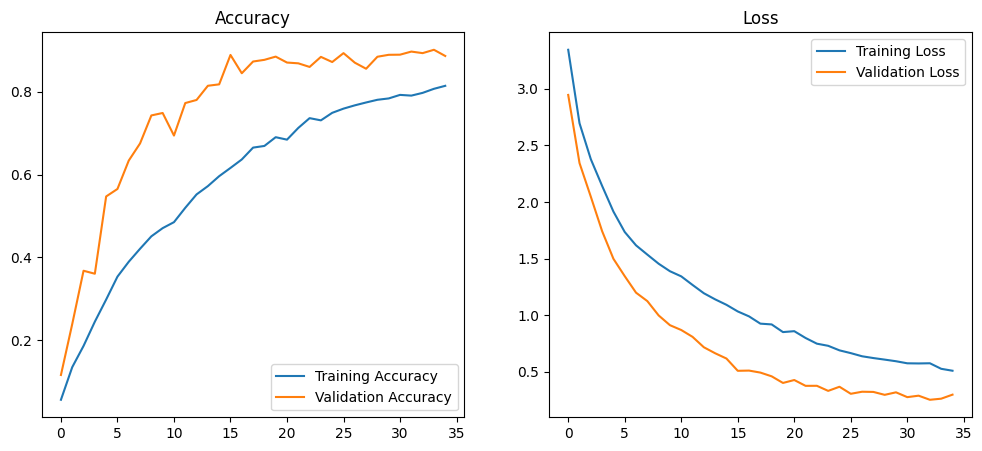

201/201 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step

Classification Report:

              precision    recall  f1-score   support

           A       0.95      1.00      0.98       180
           B       1.00      0.96      0.98       180
           C       0.73      1.00      0.84       217
           D       0.86      1.00      0.92       180
           E       1.00      1.00      1.00       180
           F       1.00      1.00      1.00       180
           G       1.00      1.00      1.00       180
           H       1.00      1.00      1.00       180
           I       0.93      0.86      0.89       207
           J       1.00      0.84      0.91       180
           K       1.00      1.00      1.00       180
           L       0.99      0.99      0.99       180
           M       0.87      1.00      0.93       180
           N       1.00      1.00      1.00       180
           O       1.00      0.74      0.85       214
           P       0.88      1.00      0.94       180
           Q

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

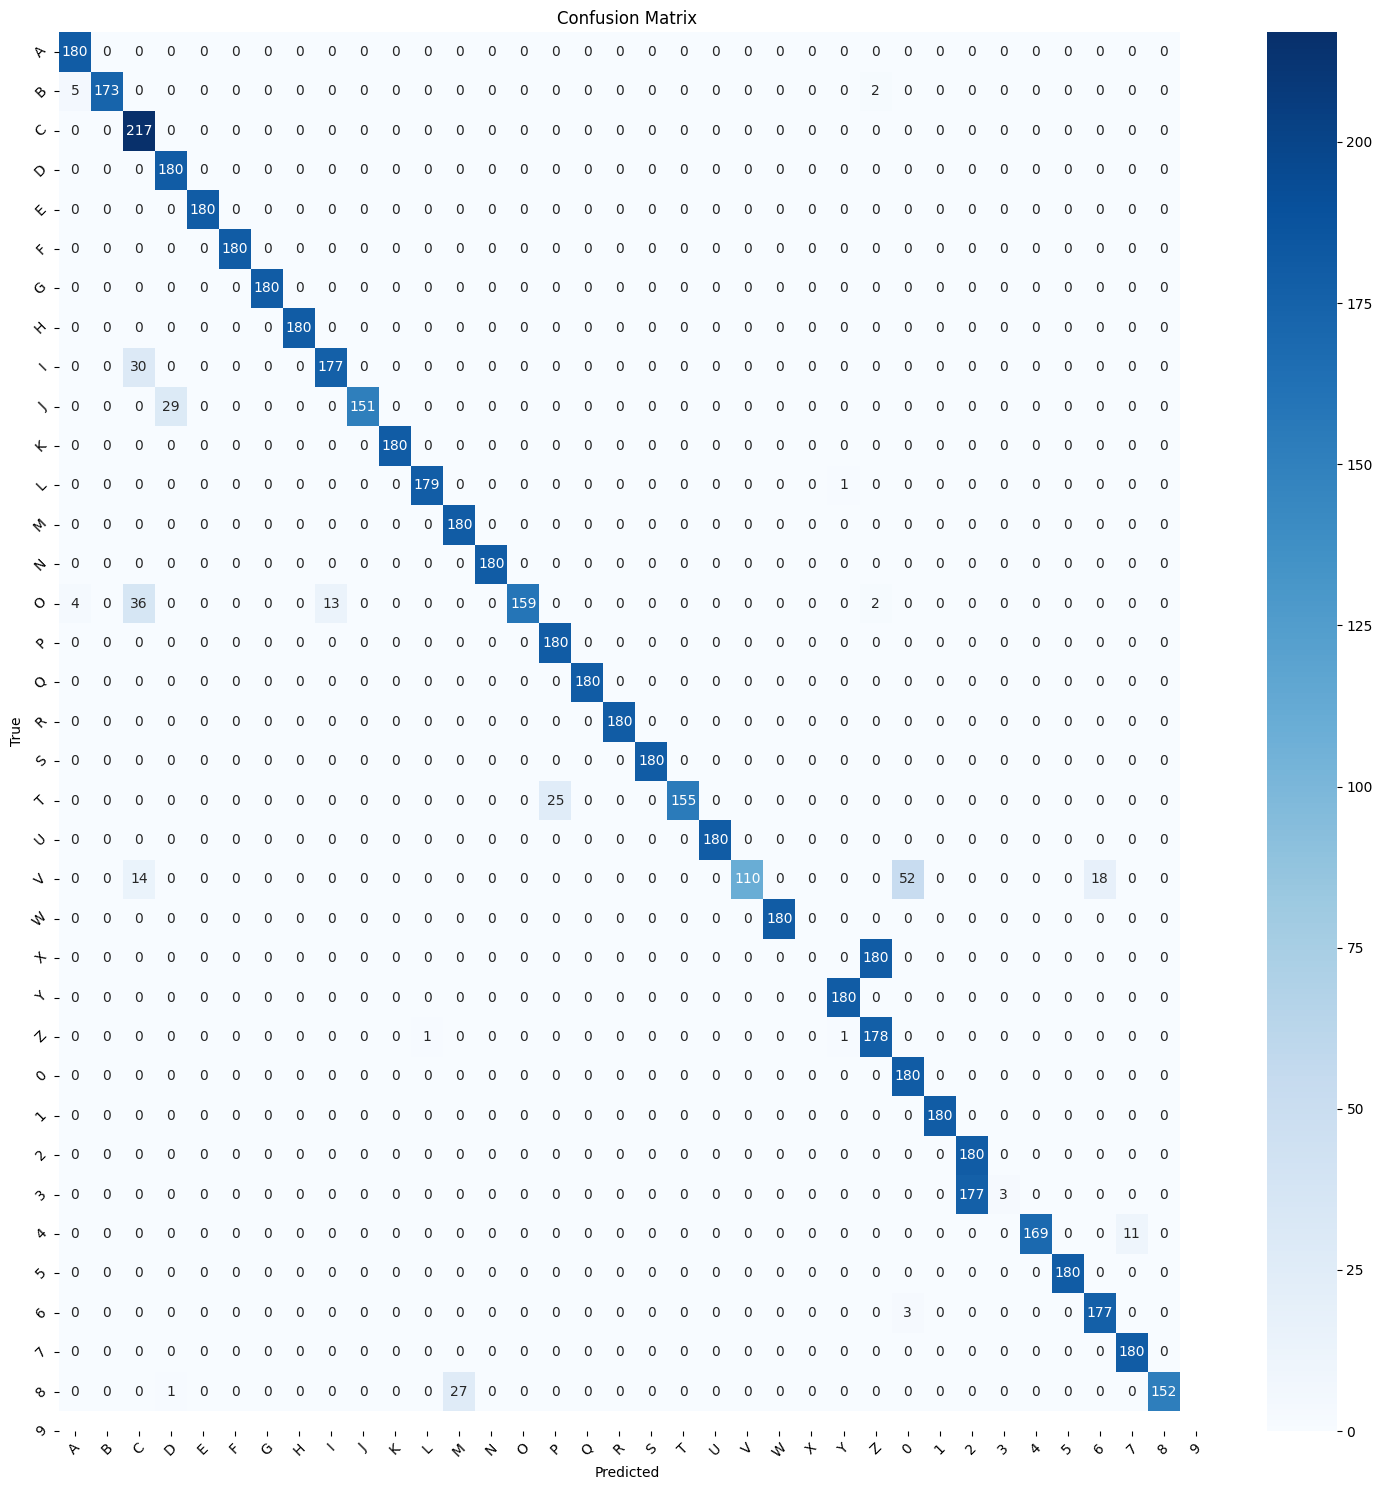

Computing predictions...
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


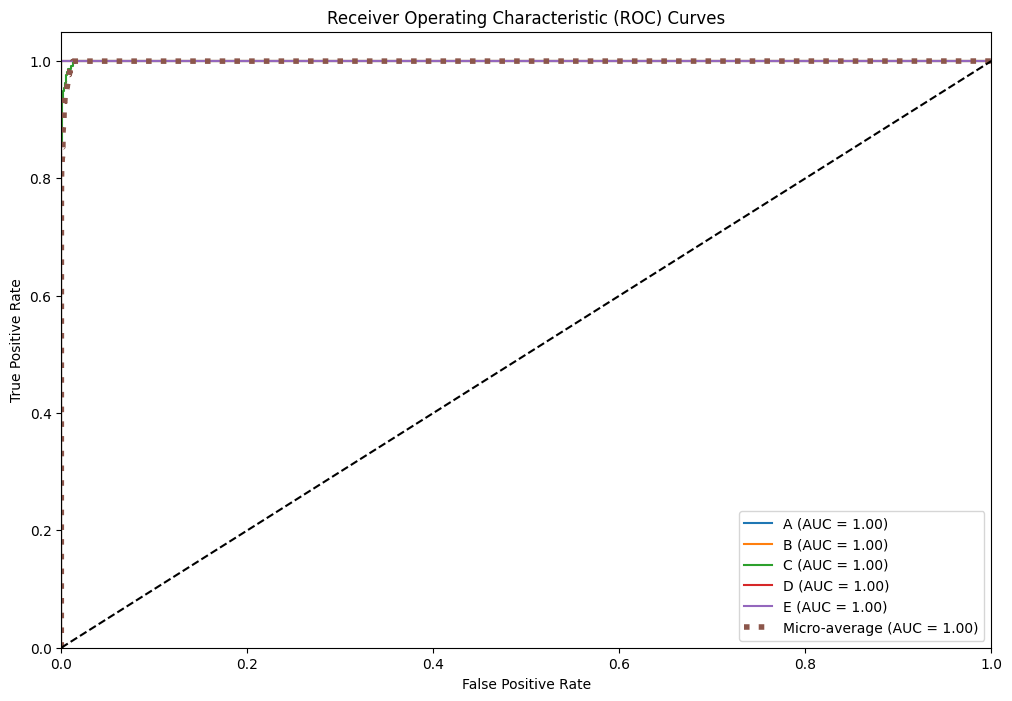

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


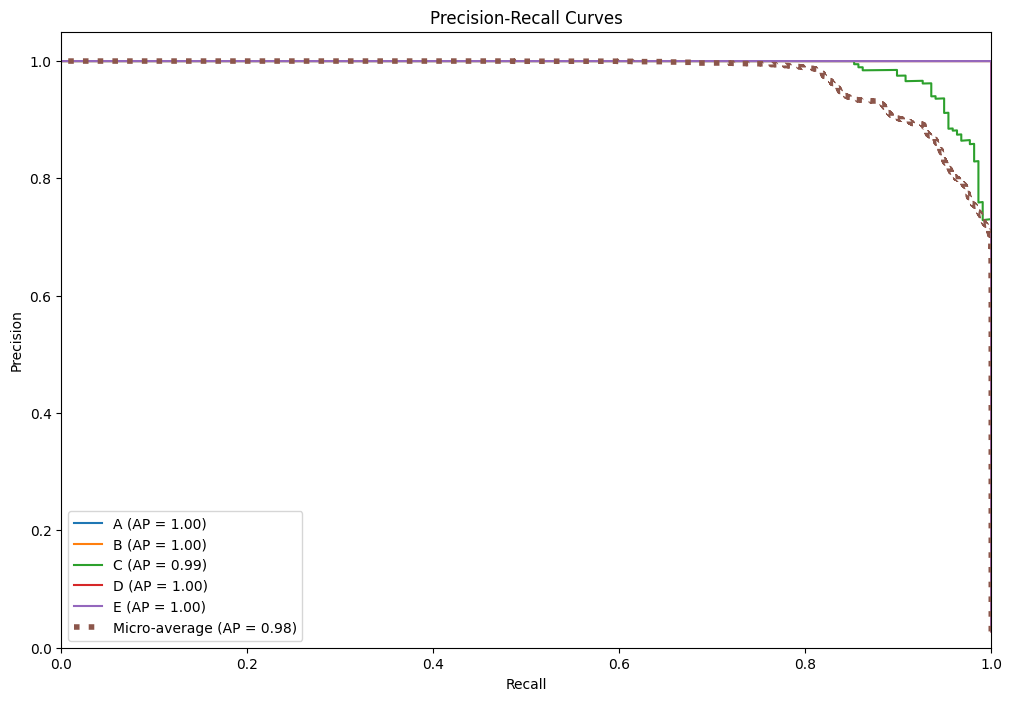

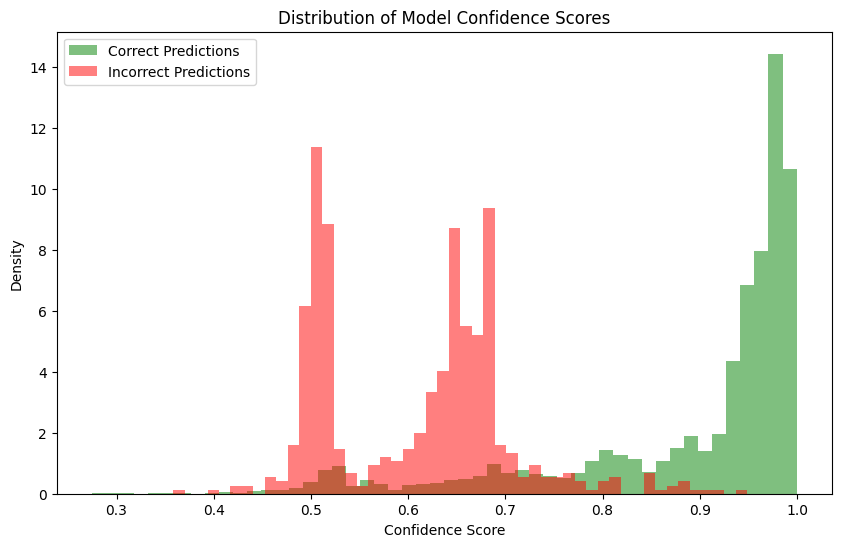

W0000 00:00:1732512692.289706      30 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "VALID" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 230 } dim { size: 230 } } } inputs { dtype: DT_FLOAT shape { dim { size: 7 } dim { size: 7 } dim { size: 3 } dim { size: 64 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multip

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


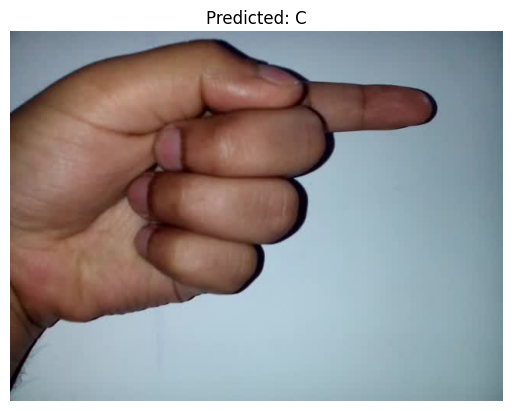

In [12]:
# Import necessary libraries
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    auc, 
    precision_recall_curve,
    average_precision_score
)
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0
import string
from datetime import datetime
import seaborn as sns
from tqdm import tqdm

        # Paths and configurations for Kaggle
INPUT_PATH = "/kaggle/input"
DATASET_PATH = os.path.join(INPUT_PATH, "indian-sign-language-isl/Indian")
MODEL_INPUT_PATH = os.path.join(INPUT_PATH, "best_model.keras")
MODEL_SAVE_PATH = "/kaggle/working/best_model.keras"
TARGET_SIZE = (224, 224)  # Adjusted for Transfer Learning
BATCH_SIZE = 32
EPOCHS = 35
NUM_CLASSES = 36  # A-Z + 0-9

def configure_gpu():
    try:
        # List all physical devices
        physical_devices = tf.config.list_physical_devices('GPU')
        if not physical_devices:
            print("No GPU devices found. Training will proceed on CPU.")
            return

        print(f"Found {len(physical_devices)} GPU(s):")
        for gpu in physical_devices:
            print(f" - {gpu.device_type}: {gpu.name}")
            
        # Configure memory growth for all GPUs
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        # Set visible devices if needed
        tf.config.set_visible_devices(physical_devices, 'GPU')
        
        # Set mixed precision policy
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        
        print("GPU configuration completed successfully")
        
    except Exception as e:
        print(f"Error configuring GPU: {str(e)}")
        print("Training will proceed with default settings")

# GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Map labels A-Z and 0-9 to integers
LABEL_MAP = {char: idx for idx, char in enumerate(string.ascii_uppercase + string.digits)}
LABEL_INV_MAP = {v: k for k, v in LABEL_MAP.items()}  # Inverse map for predictions

# Data Generator Class
class DataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=BATCH_SIZE, target_size=(224, 224), augment=False, **kwargs):
        super().__init__(**kwargs)
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment
        if self.augment:
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.array([self.load_image(p) for p in batch_paths])
        y = np.array(batch_labels)
        return X, y

    def load_image(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image at path: {image_path}")
        img_resized = cv2.resize(img, self.target_size) / 255.0
        return img_resized

# Define Transfer Learning Models
def build_model(base_model_name="VGG16"):
    input_shape = (224, 224, 3)
    
    # Define the paths for local weights
    weight_paths = {
        "VGG16": "/kaggle/input/vgg16weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
        "ResNet50": "/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
        "InceptionV3": "/kaggle/input/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
    }
    
    # Initialize base model with no weights first
    if base_model_name == "VGG16":
        base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
        base_model.load_weights(weight_paths["VGG16"])
    elif base_model_name == "ResNet50":
        base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
        base_model.load_weights(weight_paths["ResNet50"], by_name=True, skip_mismatch=True)
    elif base_model_name == "InceptionV3":
        base_model = InceptionV3(weights=None, include_top=False, input_shape=input_shape)
        base_model.load_weights(weight_paths["InceptionV3"], by_name=True, skip_mismatch=True)
    else:
        raise ValueError(f"Unsupported model: {base_model_name}")

    # Freeze the base model's layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Load and split data
def load_data():
    file_paths, labels = [], []
    for dirname, _, filenames in os.walk(DATASET_PATH):
        label = os.path.basename(dirname)
        if label in LABEL_MAP:
            label_idx = LABEL_MAP[label]
            for filename in filenames:
                file_paths.append(os.path.join(dirname, filename))
                labels.append(label_idx)

    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        file_paths, labels, test_size=0.3, stratify=labels)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)
    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)


class AdvancedMetrics:
    def __init__(self, model, test_gen, test_labels, class_names):
        self.model = model
        self.test_gen = test_gen
        self.test_labels = test_labels
        self.class_names = class_names
        self.predictions = None
        self.true_classes = np.argmax(test_labels, axis=1)

    def compute_predictions(self):
        if self.predictions is None:
            print("Computing predictions...")
            self.predictions = self.model.predict(self.test_gen)
        return self.predictions

    def plot_roc_curves(self):
        predictions = self.compute_predictions()
        plt.figure(figsize=(12, 8))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(len(self.class_names)):
            fpr[i], tpr[i], _ = roc_curve(self.test_labels[:, i], predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
            if i < 5:  # Plot only first 5 classes to avoid cluttering
                plt.plot(fpr[i], tpr[i], label=f'{self.class_names[i]} (AUC = {roc_auc[i]:.2f})')
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.test_labels.ravel(), predictions.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', 
                linestyle=':', linewidth=4)
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.show()
        
        return roc_auc

    def plot_precision_recall_curves(self):
        predictions = self.compute_predictions()
        plt.figure(figsize=(12, 8))
        
        # Compute Precision-Recall curve and average precision for each class
        precision = dict()
        recall = dict()
        avg_precision = dict()
        
        for i in range(len(self.class_names)):
            precision[i], recall[i], _ = precision_recall_curve(self.test_labels[:, i], predictions[:, i])
            avg_precision[i] = average_precision_score(self.test_labels[:, i], predictions[:, i])
            
            if i < 5:  # Plot only first 5 classes to avoid cluttering
                plt.plot(recall[i], precision[i], 
                        label=f'{self.class_names[i]} (AP = {avg_precision[i]:.2f})')
        
        # Compute micro-average precision-recall curve
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            self.test_labels.ravel(), predictions.ravel())
        avg_precision["micro"] = average_precision_score(self.test_labels, predictions, average="micro")
        
        plt.plot(recall["micro"], precision["micro"], 
                label=f'Micro-average (AP = {avg_precision["micro"]:.2f})', 
                linestyle=':', linewidth=4)
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend(loc="lower left")
        plt.show()
        
        return avg_precision

    def plot_confidence_distribution(self):
        predictions = self.compute_predictions()
        predicted_classes = np.argmax(predictions, axis=1)
        max_confidences = np.max(predictions, axis=1)
        
        # Separate confidences for correct and incorrect predictions
        correct_mask = predicted_classes == self.true_classes
        correct_confidences = max_confidences[correct_mask]
        incorrect_confidences = max_confidences[~correct_mask]
        
        plt.figure(figsize=(10, 6))
        plt.hist(correct_confidences, bins=50, alpha=0.5, label='Correct Predictions', 
                density=True, color='green')
        plt.hist(incorrect_confidences, bins=50, alpha=0.5, label='Incorrect Predictions', 
                density=True, color='red')
        plt.xlabel('Confidence Score')
        plt.ylabel('Density')
        plt.title('Distribution of Model Confidence Scores')
        plt.legend()
        plt.show()

def advanced_analytics(model, test_gen, test_labels):
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    
    # Basic metrics
    print("\nClassification Report:\n")
    print(classification_report(true_classes, predicted_classes, 
                              labels=list(range(NUM_CLASSES)), 
                              target_names=list(LABEL_MAP.keys())))

    # Confusion Matrix with improved visualization
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(LABEL_MAP.keys()),
                yticklabels=list(LABEL_MAP.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Advanced metrics using the AdvancedMetrics class
    metrics = AdvancedMetrics(model, test_gen, test_labels, list(LABEL_MAP.keys()))
    roc_auc = metrics.plot_roc_curves()
    avg_precision = metrics.plot_precision_recall_curves()
    metrics.plot_confidence_distribution()

    return roc_auc, avg_precision

def train_model(base_model_name="VGG16"):
    # Configure GPU first
    configure_gpu()
    
    # Load and prepare data
    (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = load_data()

    train_labels = to_categorical(train_labels, NUM_CLASSES)
    val_labels = to_categorical(val_labels, NUM_CLASSES)
    test_labels = to_categorical(test_labels, NUM_CLASSES)

    # Enhanced data generators
    train_gen = DataGenerator(train_paths, train_labels, augment=True)
    val_gen = DataGenerator(val_paths, val_labels)
    test_gen = DataGenerator(test_paths, test_labels)

    # Build model with GPU strategy
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = build_model(base_model_name)

    # Enhanced callbacks with proper GPU utilization
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            MODEL_SAVE_PATH,
            save_best_only=True,
            monitor='val_loss'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        TensorBoard(
            log_dir=f'logs/{datetime.now().strftime("%Y%m%d-%H%M%S")}',
            update_freq='batch'
        )
    ]

    # Configure batch size based on GPU memory
    # You can adjust these numbers based on your GPU memory
    BATCH_SIZE = 32
    if tf.config.list_physical_devices('GPU'):
        try:
            # Get GPU memory in GB
            gpu = tf.config.list_physical_devices('GPU')[0]
            gpu_memory = tf.config.experimental.get_memory_info('GPU:0')['peak'] / (1024**3)
            
            # Adjust batch size based on available memory
            if gpu_memory > 8:  # More than 8GB
                BATCH_SIZE = 64
            elif gpu_memory > 4:  # More than 4GB
                BATCH_SIZE = 32
            else:
                BATCH_SIZE = 16
                
            print(f"Using batch size: {BATCH_SIZE} based on GPU memory: {gpu_memory:.2f}GB")
        except:
            print(f"Using default batch size: {BATCH_SIZE}")
    
    # Train with GPU optimization
    try:
        with tf.device('/GPU:0'):
            history = model.fit(
                train_gen,
                validation_data=val_gen,
                epochs=EPOCHS,
                callbacks=callbacks,
                batch_size=BATCH_SIZE
            )
            
            # Log GPU utilization
            print("\nTraining completed successfully on GPU")
    except Exception as e:
        print(f"\nError during GPU training: {str(e)}")
        print("Falling back to default device")
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            callbacks=callbacks,
            batch_size=BATCH_SIZE
        )

    # Evaluate model
    plot_curves(history)
    roc_auc, avg_precision = advanced_analytics(model, test_gen, test_labels)
    return model, history, roc_auc, avg_precision
    

# [Previous code for predict_and_visualize function remains the same]

# Enhanced main function
if __name__ == "__main__":
    # Configure GPU at the start
    configure_gpu()
    
    selected_model = "ResNet50"
    model, history, roc_auc, avg_precision = train_model(selected_model)
    
    # Example prediction
    example_image = "/kaggle/input/testimg/025.jpg"
    predict_and_visualize(model, example_image)